In [1]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [3]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [4]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [5]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.8 MB/s eta 0:00:0000:010:01


In [6]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(out_ch))

    def forward(self, x):
        x = self.conv1(x) + self.conv2(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class Res_UNet_Channel_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(Res_UNet_Channel_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16, n1 * 32]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])
        self.conv6 = conv_block(filters[4], filters[5])

        self.Up6 = up_conv(filters[5], filters[4])
        self.Att6 = Attention_block(F_g=filters[4], F_l=filters[4], F_int=filters[3])
        self.Up_conv6 = conv_block(filters[5], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.Ch_att1 = ChannelAttention(in_planes=filters[0], ratio=8)
        self.Ch_att2 = ChannelAttention(in_planes=filters[1], ratio=8)
        self.Ch_att3 = ChannelAttention(in_planes=filters[2], ratio=8)
        self.Ch_att4 = ChannelAttention(in_planes=filters[3], ratio=8)
        self.Ch_att5 = ChannelAttention(in_planes=filters[4], ratio=8)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        e6 = self.Maxpool5(e5)
        e6 = self.conv6(e6)

        d6 = self.Up6(e6)

#         x5 = self.Att6(g=d6, x=self.Ch_att5(e5))
        x5 = self.Att6(g=d6, x=e5)
        d6 = torch.cat((x5, d6), dim=1)
        d6 = self.Up_conv6(d6)

        d5 = self.Up5(d6)
#         x4 = self.Att5(g=d5, x=self.Ch_att4(e4))
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4, x=self.Ch_att3(e3))
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3, x=self.Ch_att2(e2))
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2, x=self.Ch_att1(e1))
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [7]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

    

    

pred = torch.randn(16, 1, 128, 128).float()
target = torch.randint(0, 2, (16, 1, 128, 128)).float()

# # focal_loss = FocalLoss(alpha=0.75, gamma=1.0)
# # hausdorffDTLoss = HausdorffDT_Loss(reduction='none', sigmoid=True)
# # dbceloss = DiceBCELoss()
# # multi_scale_pooling_loss = MultiScalePoolingLoss(alpha=0.75, gamma=2.0, itr=3, ratio=[0.5, 0.3, 0.2])
# hausdorffDT_focal_loss = HausdorffDT_Focal_Loss(focal_weight = 0.65)

# # focal_loss(pred, target)
# # multi_scale_pooling_loss(pred, target)
# print(hausdorffDT_focal_loss(pred, target))

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [8]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
import torch.nn.functional as F

class HausdorffDT_Focal_Loss(torch.nn.Module):
    def __init__(self, initial_focal_weight=0.50):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        
        # Initialize the focal weight as a learnable parameter
        self.focal_weight = torch.nn.Parameter(torch.tensor(initial_focal_weight))

    def forward(self, inputs, targets):
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        
        # Use sigmoid to ensure the weight stays between 0 and 1
        weight = torch.sigmoid(self.focal_weight)
        
        final_loss = weight * torch.squeeze(fl) + (1 - weight) * torch.squeeze(hl)
        return torch.mean(final_loss)

class Trainer():
    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Loss function with learnable weight
        self.loss_function = HausdorffDT_Focal_Loss()

        # Training parameters
        self.opt = torch.optim.Adam([
            {'params': model.parameters()},
            {'params': self.loss_function.parameters(), 'lr': 1e-4}  # Separate learning rate for the loss weighte
        ], lr=learning_rate)
        
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    # ... (keep other methods like plot_losses, _unravel_to_numpy unchanged)
    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def eval_epoch(self, verbose=False):
        self.model.eval()
        lf = []
        ious = []
        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:
                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                ious.append(calculate_iou(out, task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))
        print(f"- Current Focal Weight: {torch.sigmoid(self.loss_function.focal_weight).item():.4f}")

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):
            autograd.set_detect_anomaly(True)
            print(f"Training epoch {epoch}")

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:
                    out = self.model(task["pred"])
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    tepoch.set_postfix(loss=loss.item())

                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 20 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss_function_state_dict': self.loss_function.state_dict(),
                    'loss': best_loss
                }, self.save_path+"final_model")
            i += 1

        print("Training complete!")

In [9]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Training epoch 0


  0%|          | 0/75 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/monai/losses/hausdorff_loss.py:171: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
100%|██████████| 75/75 [00:56<00:00,  1.33batch/s, loss=274]


- Log loss: 181.84169006347656
- mIoU: 0.00015491510566789657
- Current Focal Weight: 0.6218
Training epoch 1


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=117]


- Log loss: 164.5111846923828
- mIoU: 0.0002006715367315337
- Current Focal Weight: 0.6205
Training epoch 2


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=189] 


- Log loss: 173.46368408203125
- mIoU: 0.0004307252529542893
- Current Focal Weight: 0.6189
Training epoch 3


100%|██████████| 75/75 [00:33<00:00,  2.23batch/s, loss=124] 


- Log loss: 166.70240783691406
- mIoU: 0.0035831111017614603
- Current Focal Weight: 0.6173
Training epoch 4


100%|██████████| 75/75 [00:34<00:00,  2.20batch/s, loss=138]


- Log loss: 143.22830200195312
- mIoU: 0.0021631265990436077
- Current Focal Weight: 0.6158
Training epoch 5


100%|██████████| 75/75 [00:33<00:00,  2.23batch/s, loss=182]


- Log loss: 166.77735900878906
- mIoU: 0.010029287077486515
- Current Focal Weight: 0.6142
Training epoch 6


100%|██████████| 75/75 [00:31<00:00,  2.42batch/s, loss=129] 


- Log loss: 164.2530975341797
- mIoU: 0.006855731830000877
- Current Focal Weight: 0.6126
Training epoch 7


100%|██████████| 75/75 [00:30<00:00,  2.47batch/s, loss=126] 


- Log loss: 150.07705688476562
- mIoU: 0.006623557768762112
- Current Focal Weight: 0.6111
Training epoch 8


100%|██████████| 75/75 [00:30<00:00,  2.47batch/s, loss=196] 


- Log loss: 148.19915771484375
- mIoU: 0.0001464477536501363
- Current Focal Weight: 0.6095
Training epoch 9


100%|██████████| 75/75 [00:30<00:00,  2.50batch/s, loss=182] 


- Log loss: 133.8968963623047
- mIoU: 0.0017794037703424692
- Current Focal Weight: 0.6080
Training epoch 10


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=136] 


- Log loss: 150.24803161621094
- mIoU: 0.00897572934627533
- Current Focal Weight: 0.6064
Training epoch 11


100%|██████████| 75/75 [00:29<00:00,  2.54batch/s, loss=252] 


- Log loss: 140.09193420410156
- mIoU: 0.012442782521247864
- Current Focal Weight: 0.6049
Training epoch 12


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=103] 


- Log loss: 122.7180404663086
- mIoU: 0.01663745753467083
- Current Focal Weight: 0.6033
Training epoch 13


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=87.6]


- Log loss: 128.59181213378906
- mIoU: 0.021192345768213272
- Current Focal Weight: 0.6018
Training epoch 14


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=135] 


- Log loss: 166.9658203125
- mIoU: 0.012402549386024475
- Current Focal Weight: 0.6002
Training epoch 15


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=124] 


- Log loss: 130.3260040283203
- mIoU: 0.007011312060058117
- Current Focal Weight: 0.5986
Training epoch 16


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=112] 


- Log loss: 119.9764404296875
- mIoU: 0.015699436888098717
- Current Focal Weight: 0.5970
Training epoch 17


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=120] 


- Log loss: 132.290283203125
- mIoU: 0.015603666193783283
- Current Focal Weight: 0.5955
Training epoch 18


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=78.9]


- Log loss: 116.49458312988281
- mIoU: 0.015470019541680813
- Current Focal Weight: 0.5938
Training epoch 19


100%|██████████| 75/75 [00:27<00:00,  2.69batch/s, loss=61.6]


- Log loss: 113.2108154296875
- mIoU: 0.02217845991253853
- Current Focal Weight: 0.5923


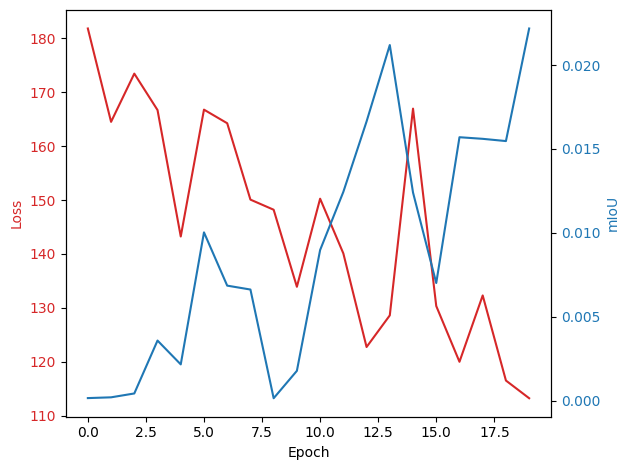

Training epoch 20


100%|██████████| 75/75 [00:27<00:00,  2.68batch/s, loss=108] 


- Log loss: 112.46833038330078
- mIoU: 0.0169844850897789
- Current Focal Weight: 0.5907
Training epoch 21


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=97.9]


- Log loss: 109.2349624633789
- mIoU: 0.026237253099679947
- Current Focal Weight: 0.5891
Training epoch 22


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=59.7]


- Log loss: 118.76766204833984
- mIoU: 0.014017736539244652
- Current Focal Weight: 0.5874
Training epoch 23


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=99.9]


- Log loss: 114.14781188964844
- mIoU: 0.025588491931557655
- Current Focal Weight: 0.5859
Training epoch 24


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=114] 


- Log loss: 123.48893737792969
- mIoU: 0.018853412941098213
- Current Focal Weight: 0.5843
Training epoch 25


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=255] 


- Log loss: 102.83988189697266
- mIoU: 0.03324224427342415
- Current Focal Weight: 0.5827
Training epoch 26


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=75.7]


- Log loss: 125.49500274658203
- mIoU: 0.014422687701880932
- Current Focal Weight: 0.5811
Training epoch 27


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=102] 


- Log loss: 103.73392486572266
- mIoU: 0.028799721971154213
- Current Focal Weight: 0.5794
Training epoch 28


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=136] 


- Log loss: 109.48452758789062
- mIoU: 0.028990810737013817
- Current Focal Weight: 0.5778
Training epoch 29


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=61.5]


- Log loss: 101.2774658203125
- mIoU: 0.03490709513425827
- Current Focal Weight: 0.5762
Training epoch 30


100%|██████████| 75/75 [00:27<00:00,  2.73batch/s, loss=123] 


- Log loss: 103.883056640625
- mIoU: 0.03506360575556755
- Current Focal Weight: 0.5746
Training epoch 31


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=83.6]


- Log loss: 106.12666320800781
- mIoU: 0.029600756242871284
- Current Focal Weight: 0.5730
Training epoch 32


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=104] 


- Log loss: 96.90766143798828
- mIoU: 0.027397435158491135
- Current Focal Weight: 0.5714
Training epoch 33


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=104] 


- Log loss: 100.23778533935547
- mIoU: 0.04033343866467476
- Current Focal Weight: 0.5698
Training epoch 34


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=85.2]


- Log loss: 103.49789428710938
- mIoU: 0.02875955030322075
- Current Focal Weight: 0.5681
Training epoch 35


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=99.7]


- Log loss: 89.6154556274414
- mIoU: 0.04142148420214653
- Current Focal Weight: 0.5665
Training epoch 36


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=63.3]


- Log loss: 98.03855895996094
- mIoU: 0.03220019489526749
- Current Focal Weight: 0.5649
Training epoch 37


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=66]  


- Log loss: 95.19085693359375
- mIoU: 0.03653772920370102
- Current Focal Weight: 0.5633
Training epoch 38


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=67.1]


- Log loss: 95.58607482910156
- mIoU: 0.03801334276795387
- Current Focal Weight: 0.5616
Training epoch 39


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=73.6]


- Log loss: 96.86662292480469
- mIoU: 0.02957698330283165
- Current Focal Weight: 0.5600


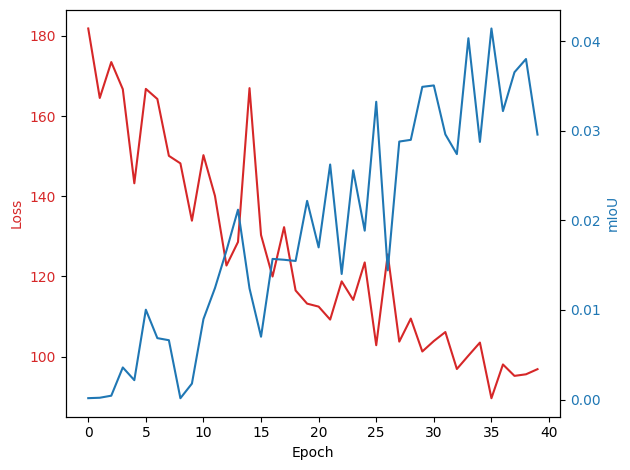

Training epoch 40


100%|██████████| 75/75 [00:27<00:00,  2.78batch/s, loss=154] 


- Log loss: 88.04448699951172
- mIoU: 0.03708116337656975
- Current Focal Weight: 0.5584
Training epoch 41


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=68.1]


- Log loss: 87.7430419921875
- mIoU: 0.0348627008497715
- Current Focal Weight: 0.5568
Training epoch 42


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=58.2]


- Log loss: 97.49608612060547
- mIoU: 0.03164263442158699
- Current Focal Weight: 0.5552
Training epoch 43


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=61.5]


- Log loss: 89.00220489501953
- mIoU: 0.03621438890695572
- Current Focal Weight: 0.5536
Training epoch 44


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=64.6]


- Log loss: 94.59319305419922
- mIoU: 0.028021054342389107
- Current Focal Weight: 0.5520
Training epoch 45


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=97.8]


- Log loss: 89.93558502197266
- mIoU: 0.03707504644989967
- Current Focal Weight: 0.5505
Training epoch 46


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=101] 


- Log loss: 91.65748596191406
- mIoU: 0.03166723623871803
- Current Focal Weight: 0.5489
Training epoch 47


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=119] 


- Log loss: 90.76361846923828
- mIoU: 0.030097320675849915
- Current Focal Weight: 0.5472
Training epoch 48


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=74.4]


- Log loss: 91.60698699951172
- mIoU: 0.02589069865643978
- Current Focal Weight: 0.5455
Training epoch 49


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=67.5]


- Log loss: 87.05010223388672
- mIoU: 0.03941015154123306
- Current Focal Weight: 0.5439
Training epoch 50


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=60.3]


- Log loss: 83.02436828613281
- mIoU: 0.03847076743841171
- Current Focal Weight: 0.5423
Training epoch 51


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=82.3]


- Log loss: 92.8822250366211
- mIoU: 0.03435123339295387
- Current Focal Weight: 0.5407
Training epoch 52


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=78.9]


- Log loss: 120.74043273925781
- mIoU: 0.02730810083448887
- Current Focal Weight: 0.5391
Training epoch 53


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=36]  


- Log loss: 84.341552734375
- mIoU: 0.031695201992988586
- Current Focal Weight: 0.5375
Training epoch 54


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=70.8]


- Log loss: 87.663818359375
- mIoU: 0.03766641765832901
- Current Focal Weight: 0.5360
Training epoch 55


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=39.4]


- Log loss: 84.29222106933594
- mIoU: 0.03480049967765808
- Current Focal Weight: 0.5344
Training epoch 56


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=75.7]


- Log loss: 78.76315307617188
- mIoU: 0.0406176894903183
- Current Focal Weight: 0.5327
Training epoch 57


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=34.7]


- Log loss: 87.79804229736328
- mIoU: 0.03593243658542633
- Current Focal Weight: 0.5311
Training epoch 58


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=107] 


- Log loss: 84.3853988647461
- mIoU: 0.04132340848445892
- Current Focal Weight: 0.5295
Training epoch 59


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=105] 


- Log loss: 88.85470581054688
- mIoU: 0.03148048743605614
- Current Focal Weight: 0.5279


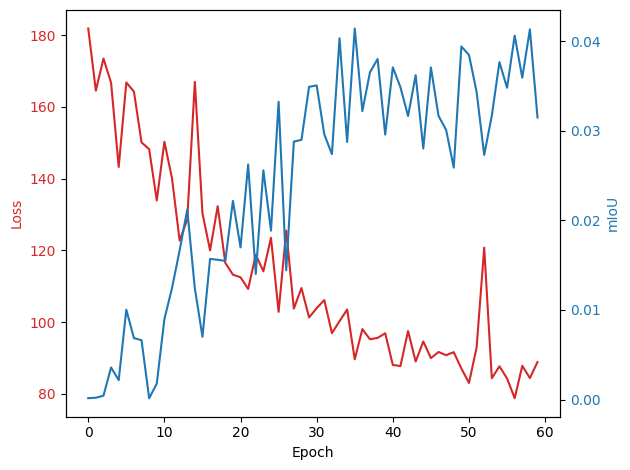

Training epoch 60


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=99.5]


- Log loss: 82.67021942138672
- mIoU: 0.036265432834625244
- Current Focal Weight: 0.5262
Training epoch 61


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=43.6]


- Log loss: 79.81834411621094
- mIoU: 0.03288361802697182
- Current Focal Weight: 0.5246
Training epoch 62


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=46.9]


- Log loss: 77.12871551513672
- mIoU: 0.04211167246103287
- Current Focal Weight: 0.5230
Training epoch 63


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=76.1]


- Log loss: 84.31718444824219
- mIoU: 0.0385061539709568
- Current Focal Weight: 0.5214
Training epoch 64


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=51.3]


- Log loss: 87.0611343383789
- mIoU: 0.039851538836956024
- Current Focal Weight: 0.5197
Training epoch 65


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=84.5]


- Log loss: 85.86227416992188
- mIoU: 0.030744457617402077
- Current Focal Weight: 0.5180
Training epoch 66


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=38]  


- Log loss: 73.46424865722656
- mIoU: 0.039101261645555496
- Current Focal Weight: 0.5165
Training epoch 67


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=42.6]


- Log loss: 84.25732421875
- mIoU: 0.040549054741859436
- Current Focal Weight: 0.5149
Training epoch 68


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=96.5]


- Log loss: 77.81414794921875
- mIoU: 0.036952290683984756
- Current Focal Weight: 0.5133
Training epoch 69


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=57.9]


- Log loss: 83.72604370117188
- mIoU: 0.0435418039560318
- Current Focal Weight: 0.5117
Training epoch 70


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=33]  


- Log loss: 75.1392822265625
- mIoU: 0.04233498126268387
- Current Focal Weight: 0.5100
Training epoch 71


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=72.9]


- Log loss: 77.08609771728516
- mIoU: 0.03925918787717819
- Current Focal Weight: 0.5084
Training epoch 72


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=38.3]


- Log loss: 82.3542709350586
- mIoU: 0.036488477140665054
- Current Focal Weight: 0.5068
Training epoch 73


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=55.2]


- Log loss: 84.10467529296875
- mIoU: 0.04152955487370491
- Current Focal Weight: 0.5052
Training epoch 74


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=39.1]


- Log loss: 78.74842834472656
- mIoU: 0.03794220834970474
- Current Focal Weight: 0.5037
Training epoch 75


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=51.2]


- Log loss: 75.39618682861328
- mIoU: 0.04162391275167465
- Current Focal Weight: 0.5029
Training epoch 76


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=53.1]


- Log loss: 74.27510833740234
- mIoU: 0.039306506514549255
- Current Focal Weight: 0.5022
Training epoch 77


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=34.6]


- Log loss: 89.1885986328125
- mIoU: 0.03490586578845978
- Current Focal Weight: 0.5014
Training epoch 78


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=59.9]


- Log loss: 73.58191680908203
- mIoU: 0.040644321590662
- Current Focal Weight: 0.5006
Training epoch 79


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=55.7]


- Log loss: 71.26732635498047
- mIoU: 0.04259829595685005
- Current Focal Weight: 0.4999


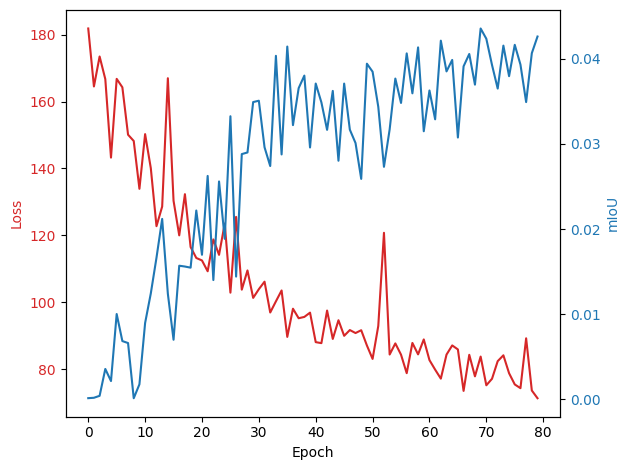

Training epoch 80


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=53.1]


- Log loss: 68.42342376708984
- mIoU: 0.045149948447942734
- Current Focal Weight: 0.4991
Training epoch 81


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=26]  


- Log loss: 72.5576171875
- mIoU: 0.044880349189043045
- Current Focal Weight: 0.4983
Training epoch 82


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=21.2]


- Log loss: 65.68123626708984
- mIoU: 0.04504471272230148
- Current Focal Weight: 0.4976
Training epoch 83


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=38.3]


- Log loss: 65.16824340820312
- mIoU: 0.044638313353061676
- Current Focal Weight: 0.4968
Training epoch 84


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=38.6]


- Log loss: 68.89031219482422
- mIoU: 0.03940886631608009
- Current Focal Weight: 0.4961
Training epoch 85


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=35.4]


- Log loss: 68.81156921386719
- mIoU: 0.04424295574426651
- Current Focal Weight: 0.4953
Training epoch 86


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=23.7]


- Log loss: 67.06787109375
- mIoU: 0.04506372660398483
- Current Focal Weight: 0.4946
Training epoch 87


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=28.5]


- Log loss: 64.68049621582031
- mIoU: 0.04626363515853882
- Current Focal Weight: 0.4937
Training epoch 88


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=39.6]


- Log loss: 67.87782287597656
- mIoU: 0.04249502718448639
- Current Focal Weight: 0.4930
Training epoch 89


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=39.7]


- Log loss: 70.79650115966797
- mIoU: 0.04048646241426468
- Current Focal Weight: 0.4923
Training epoch 90


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=58.7]


- Log loss: 69.77911376953125
- mIoU: 0.0432635061442852
- Current Focal Weight: 0.4915
Training epoch 91


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=36.8]


- Log loss: 69.4468994140625
- mIoU: 0.044771213084459305
- Current Focal Weight: 0.4907
Training epoch 92


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=50.8]


- Log loss: 69.08513641357422
- mIoU: 0.04439003765583038
- Current Focal Weight: 0.4900
Training epoch 93


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=39]  


- Log loss: 74.84552764892578
- mIoU: 0.042388975620269775
- Current Focal Weight: 0.4892
Training epoch 94


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=41.1]


- Log loss: 65.82072448730469
- mIoU: 0.04401286691427231
- Current Focal Weight: 0.4884
Training epoch 95


100%|██████████| 75/75 [00:25<00:00,  2.90batch/s, loss=59.8]


- Log loss: 70.78009796142578
- mIoU: 0.03932715207338333
- Current Focal Weight: 0.4876
Training epoch 96


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=29.1]


- Log loss: 66.3814468383789
- mIoU: 0.04478263109922409
- Current Focal Weight: 0.4872
Training epoch 97


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=33.2]


- Log loss: 63.29023361206055
- mIoU: 0.04359700530767441
- Current Focal Weight: 0.4868
Training epoch 98


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=29.3]


- Log loss: 67.83336639404297
- mIoU: 0.04256466403603554
- Current Focal Weight: 0.4865
Training epoch 99


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=32.3]


- Log loss: 68.45443725585938
- mIoU: 0.04361281171441078
- Current Focal Weight: 0.4861


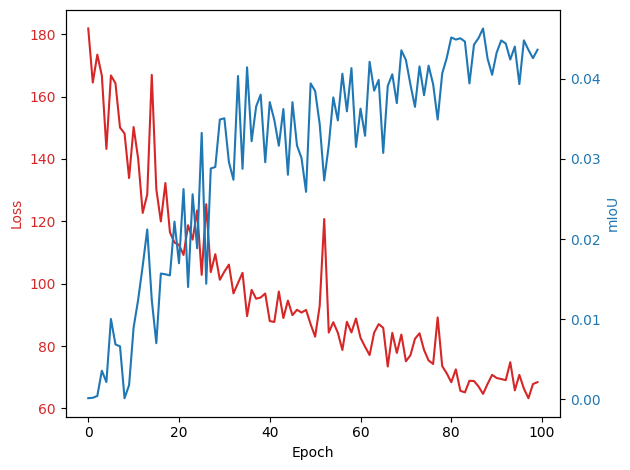

Training epoch 100


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=51.2]


- Log loss: 70.2994384765625
- mIoU: 0.042936306446790695
- Current Focal Weight: 0.4857
Training epoch 101


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=67.1]


- Log loss: 68.0367202758789
- mIoU: 0.04563112556934357
- Current Focal Weight: 0.4854
Training epoch 102


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=30.6]


- Log loss: 70.13609313964844
- mIoU: 0.044769030064344406
- Current Focal Weight: 0.4850
Training epoch 103


100%|██████████| 75/75 [00:25<00:00,  2.89batch/s, loss=39.2]


- Log loss: 69.10646057128906
- mIoU: 0.04312455654144287
- Current Focal Weight: 0.4846
Training epoch 104


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=42.1]


- Log loss: 67.29705810546875
- mIoU: 0.04278264567255974
- Current Focal Weight: 0.4842
Training epoch 105


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=25.7]


- Log loss: 65.83187866210938
- mIoU: 0.045772772282361984
- Current Focal Weight: 0.4839
Training epoch 106


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=25.1]


- Log loss: 66.55937957763672
- mIoU: 0.044967636466026306
- Current Focal Weight: 0.4837
Training epoch 107


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=30.4]


- Log loss: 64.7782974243164
- mIoU: 0.047647055238485336
- Current Focal Weight: 0.4835
Training epoch 108


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=19.9]


- Log loss: 64.65108489990234
- mIoU: 0.04678656905889511
- Current Focal Weight: 0.4833
Training epoch 109


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=28.9]


- Log loss: 61.906585693359375
- mIoU: 0.045250095427036285
- Current Focal Weight: 0.4831
Training epoch 110


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=30.6]


- Log loss: 61.67802810668945
- mIoU: 0.04598414525389671
- Current Focal Weight: 0.4829
Training epoch 111


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=30.4]


- Log loss: 66.50530242919922
- mIoU: 0.04054183512926102
- Current Focal Weight: 0.4827
Training epoch 112


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=47.8]


- Log loss: 65.00485229492188
- mIoU: 0.04595242813229561
- Current Focal Weight: 0.4825
Training epoch 113


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=33.4]


- Log loss: 65.4053726196289
- mIoU: 0.04148426279425621
- Current Focal Weight: 0.4823
Training epoch 114


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=32.7]


- Log loss: 62.89500427246094
- mIoU: 0.04570147767663002
- Current Focal Weight: 0.4821
Training epoch 115


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=57.9]


- Log loss: 65.10908508300781
- mIoU: 0.04444725811481476
- Current Focal Weight: 0.4819
Training epoch 116


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=27.8]


- Log loss: 65.2677993774414
- mIoU: 0.04454692825675011
- Current Focal Weight: 0.4817
Training epoch 117


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=34.3]


- Log loss: 64.5720443725586
- mIoU: 0.04467229172587395
- Current Focal Weight: 0.4815
Training epoch 118


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=49.5]


- Log loss: 61.20469284057617
- mIoU: 0.046042099595069885
- Current Focal Weight: 0.4814
Training epoch 119


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=18.7]


- Log loss: 64.266845703125
- mIoU: 0.044585347175598145
- Current Focal Weight: 0.4811


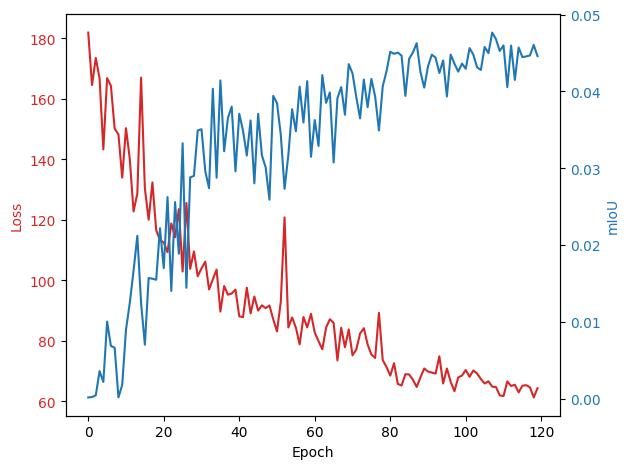

Training epoch 120


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=31]  


- Log loss: 60.770179748535156
- mIoU: 0.04828270524740219
- Current Focal Weight: 0.4810
Training epoch 121


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=15.7]


- Log loss: 63.56686782836914
- mIoU: 0.04530758783221245
- Current Focal Weight: 0.4808
Training epoch 122


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=33.8]


- Log loss: 74.47117614746094
- mIoU: 0.04174827039241791
- Current Focal Weight: 0.4806
Training epoch 123


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=40.8]


- Log loss: 70.01158142089844
- mIoU: 0.04560445249080658
- Current Focal Weight: 0.4804
Training epoch 124


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=28.1]


- Log loss: 70.34197235107422
- mIoU: 0.043474502861499786
- Current Focal Weight: 0.4802
Training epoch 125


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=29.1]


- Log loss: 66.64228820800781
- mIoU: 0.0453723669052124
- Current Focal Weight: 0.4799
Training epoch 126


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=22.6]


- Log loss: 66.89280700683594
- mIoU: 0.04382404685020447
- Current Focal Weight: 0.4797
Training epoch 127


100%|██████████| 75/75 [00:26<00:00,  2.88batch/s, loss=32.4]


- Log loss: 64.48861694335938
- mIoU: 0.044500332325696945
- Current Focal Weight: 0.4796
Training epoch 128


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=45.6]


- Log loss: 67.34091186523438
- mIoU: 0.04607967287302017
- Current Focal Weight: 0.4794
Training epoch 129


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=34.4]


- Log loss: 65.80384063720703
- mIoU: 0.04523468762636185
- Current Focal Weight: 0.4793
Training epoch 130


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=29.3]


- Log loss: 66.2154541015625
- mIoU: 0.04519464820623398
- Current Focal Weight: 0.4792
Training epoch 131


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=28.6]


- Log loss: 67.26359558105469
- mIoU: 0.04546545818448067
- Current Focal Weight: 0.4791
Training epoch 132


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=27.3]


- Log loss: 68.24302673339844
- mIoU: 0.04472951218485832
- Current Focal Weight: 0.4790
Training epoch 133


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=34]  


- Log loss: 65.32794952392578
- mIoU: 0.043746672570705414
- Current Focal Weight: 0.4789
Training epoch 134


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=40.5]


- Log loss: 66.00028228759766
- mIoU: 0.04532243311405182
- Current Focal Weight: 0.4788
Training epoch 135


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=31.4]


- Log loss: 64.38567352294922
- mIoU: 0.04531442001461983
- Current Focal Weight: 0.4787
Training epoch 136


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=40.4]


- Log loss: 64.9085693359375
- mIoU: 0.045233339071273804
- Current Focal Weight: 0.4786
Training epoch 137


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=27.9]


- Log loss: 65.72138977050781
- mIoU: 0.04522496461868286
- Current Focal Weight: 0.4785
Training epoch 138


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=16.7]


- Log loss: 65.97596740722656
- mIoU: 0.0433235764503479
- Current Focal Weight: 0.4784
Training epoch 139


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=34.3]


- Log loss: 62.662471771240234
- mIoU: 0.045199256390333176
- Current Focal Weight: 0.4784


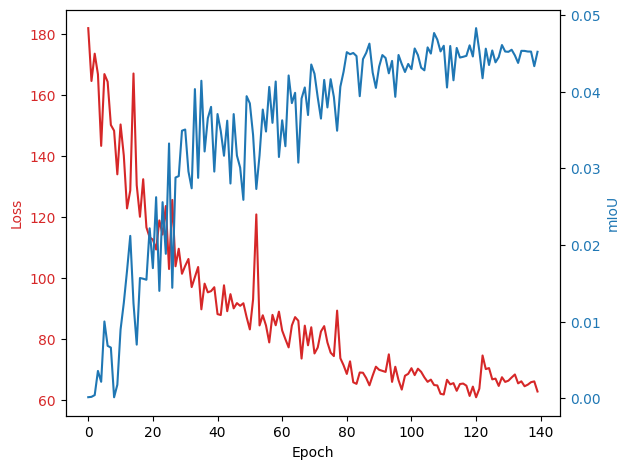

Training epoch 140


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=23.4]


- Log loss: 64.23955535888672
- mIoU: 0.04659363999962807
- Current Focal Weight: 0.4783
Training epoch 141


100%|██████████| 75/75 [00:31<00:00,  2.39batch/s, loss=27.6]


- Log loss: 68.80767059326172
- mIoU: 0.043267909437417984
- Current Focal Weight: 0.4783
Training epoch 142


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=17.4]


- Log loss: 67.68899536132812
- mIoU: 0.04502968490123749
- Current Focal Weight: 0.4782
Training epoch 143


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=19]  


- Log loss: 65.19315338134766
- mIoU: 0.046400245279073715
- Current Focal Weight: 0.4782
Training epoch 144


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=23.6]


- Log loss: 63.827552795410156
- mIoU: 0.043745242059230804
- Current Focal Weight: 0.4781
Training epoch 145


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=58.2]


- Log loss: 65.60582733154297
- mIoU: 0.04582697153091431
- Current Focal Weight: 0.4781
Training epoch 146


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=24.9]


- Log loss: 65.13865661621094
- mIoU: 0.04486977681517601
- Current Focal Weight: 0.4781
Training epoch 147


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=33.6]


- Log loss: 64.81285095214844
- mIoU: 0.04860106483101845
- Current Focal Weight: 0.4781
Training epoch 148


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=15.5]


- Log loss: 65.61878967285156
- mIoU: 0.04653443768620491
- Current Focal Weight: 0.4780
Training epoch 149


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=28.3]


- Log loss: 65.72747039794922
- mIoU: 0.04526533931493759
- Current Focal Weight: 0.4780


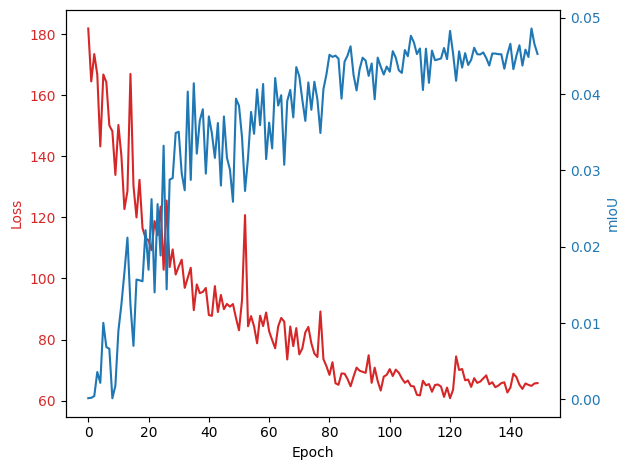

Training complete!


In [10]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
# loss_fn = HausdorffDT_Focal_Loss(focal_weight = 0.65)

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=150)

In [11]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [12]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [13]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  120


/tmp/ipykernel_36/1094549648.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


In [14]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
from torch.utils.data import DataLoader



def calculate_metrics(pred, target, epsilon=1e-6):
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# Load the trained model and loss function
checkpoint = torch.load('/kaggle/working/train_out/final_model')
model.eval()

loss_fn = HausdorffDT_Focal_Loss()
loss_fn.load_state_dict(checkpoint['loss_function_state_dict'])

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        with torch.no_grad():
            out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out).unsqueeze(0), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")
print(f"Final Focal Weight: {torch.sigmoid(loss_fn.focal_weight).item():.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
    "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr,
    "focal_weight": torch.sigmoid(loss_fn.focal_weight).item()
})

/tmp/ipykernel_36/2665406662.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/train_out/final_model')
  0%|          | 1/250 [00

Mean Loss: 108.0500
Mean IoU: 0.5821
Mean Accuracy: 0.9838
Mean Recall: 0.7216
Mean Balanced Accuracy: 0.8572
Mean False Positive Rate: 0.0060
Mean False Negative Rate: 0.7925
Final Focal Weight: 0.4780


neg
100.0


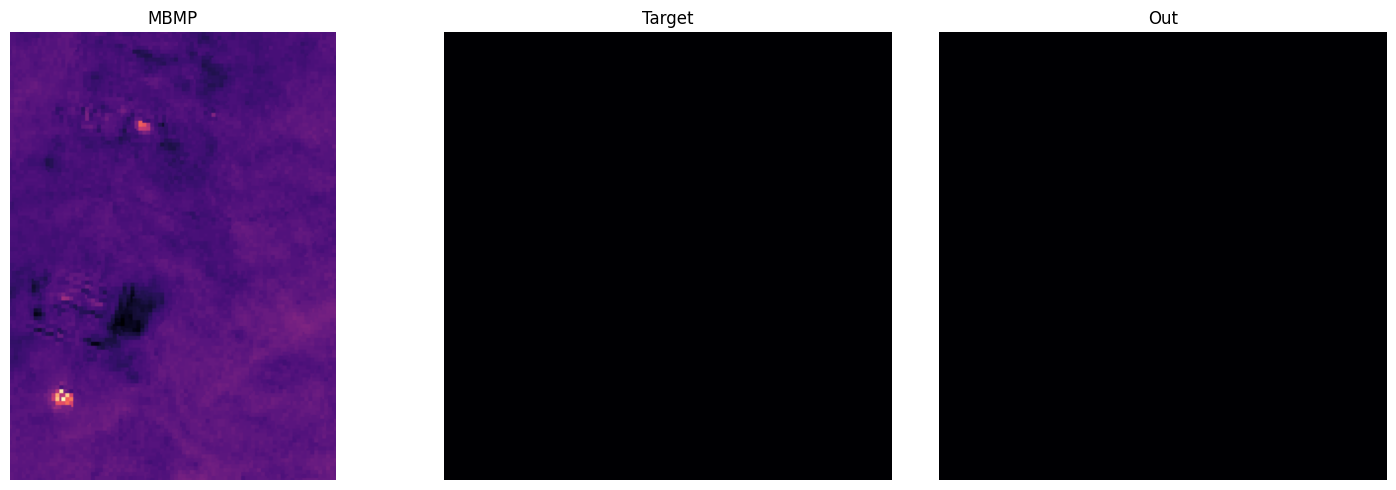

neg
100.0


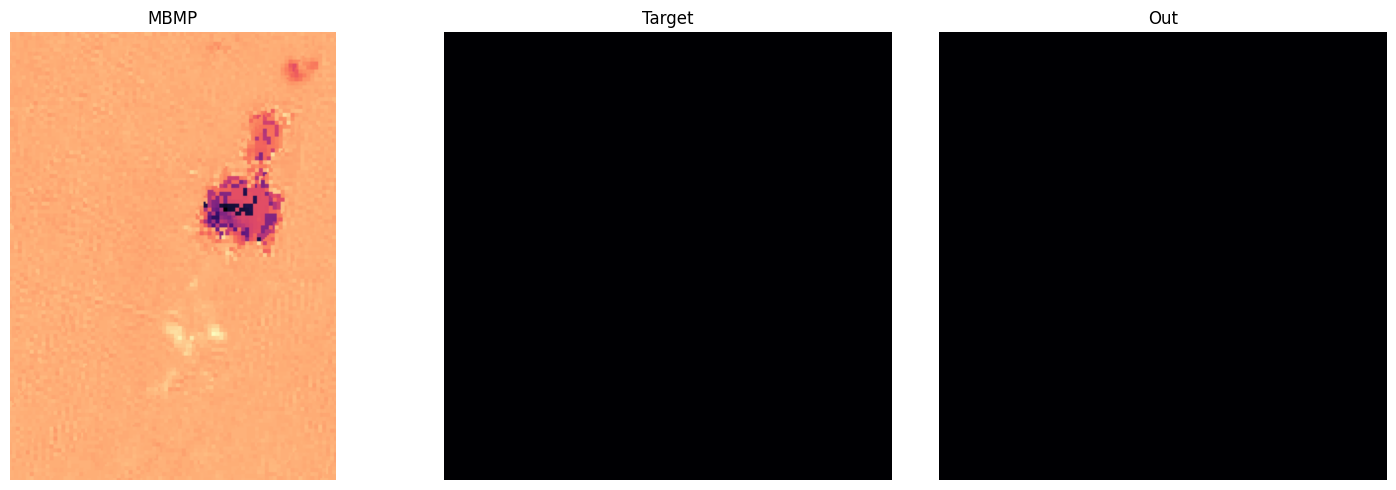

neg
100.0


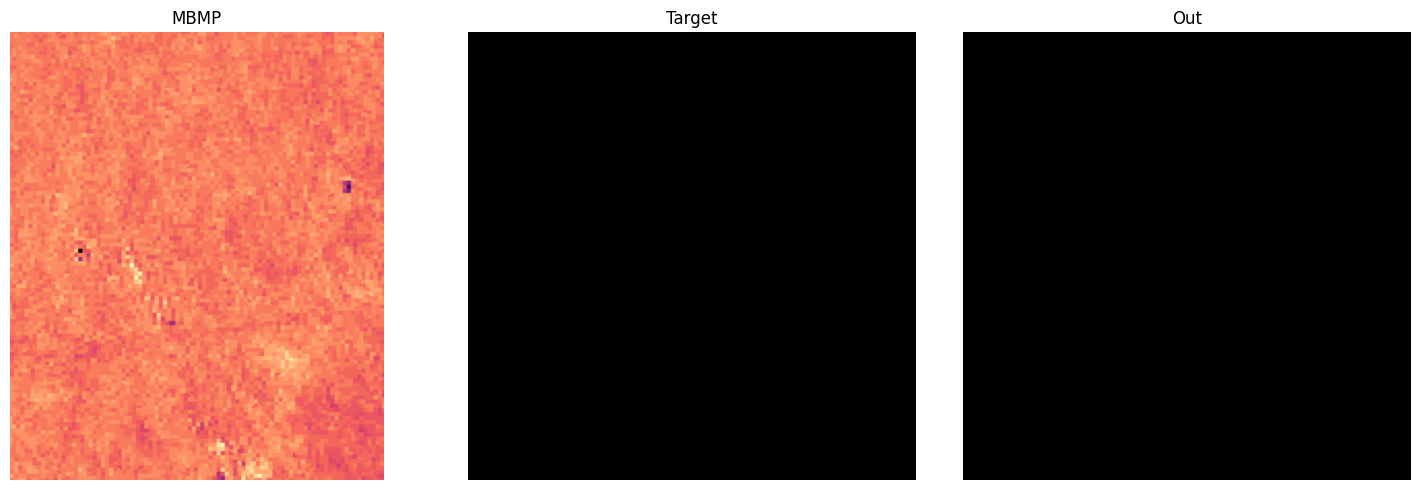

neg
100.0


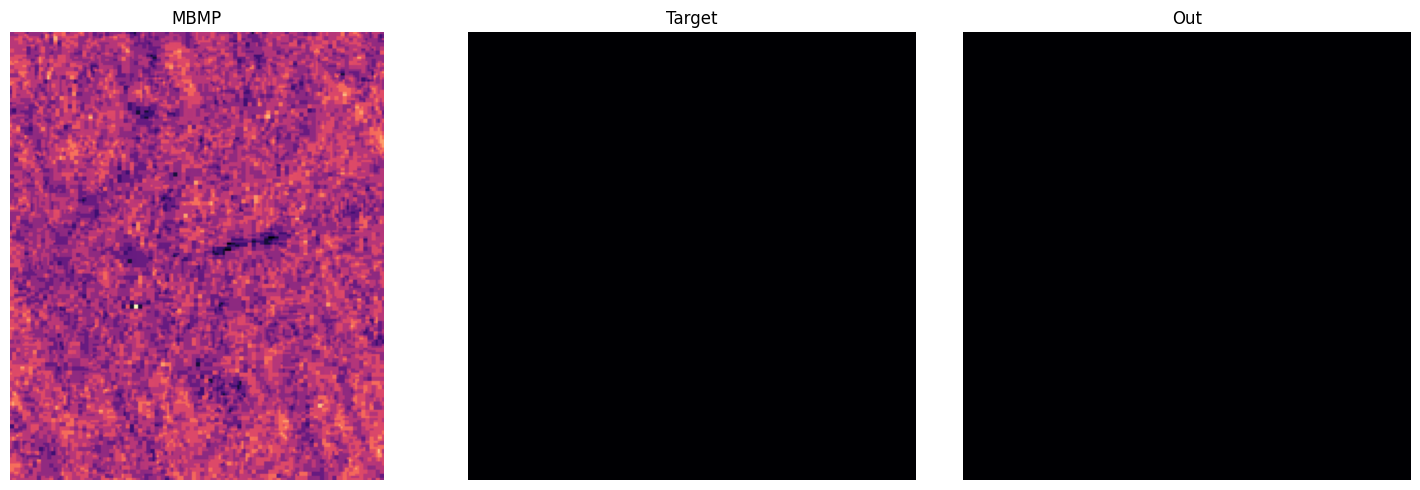

neg
100.0


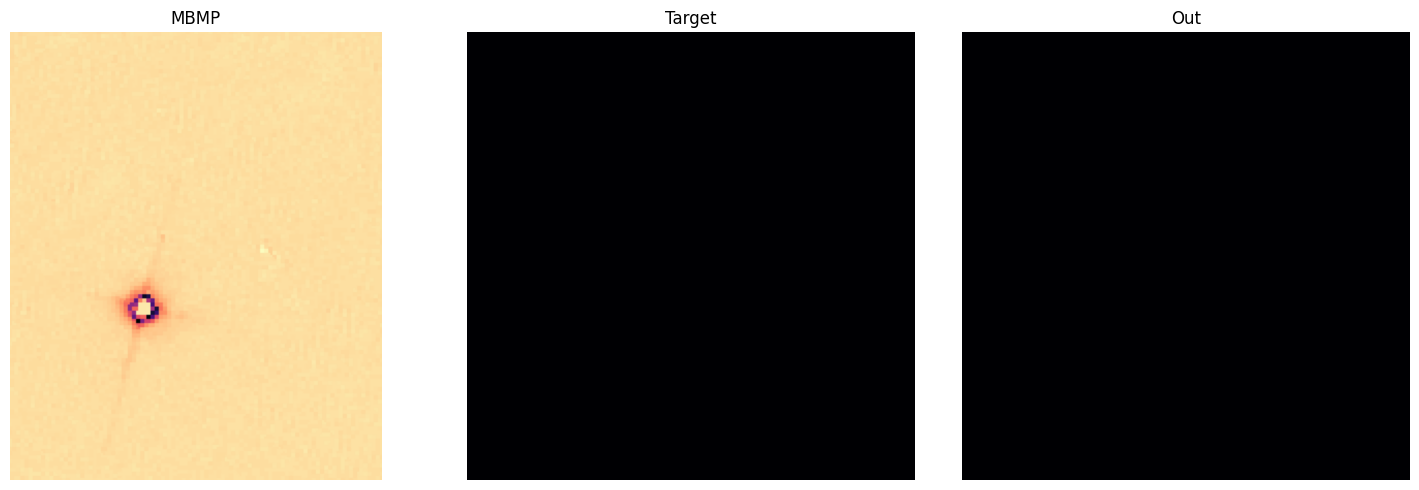

neg
100.0


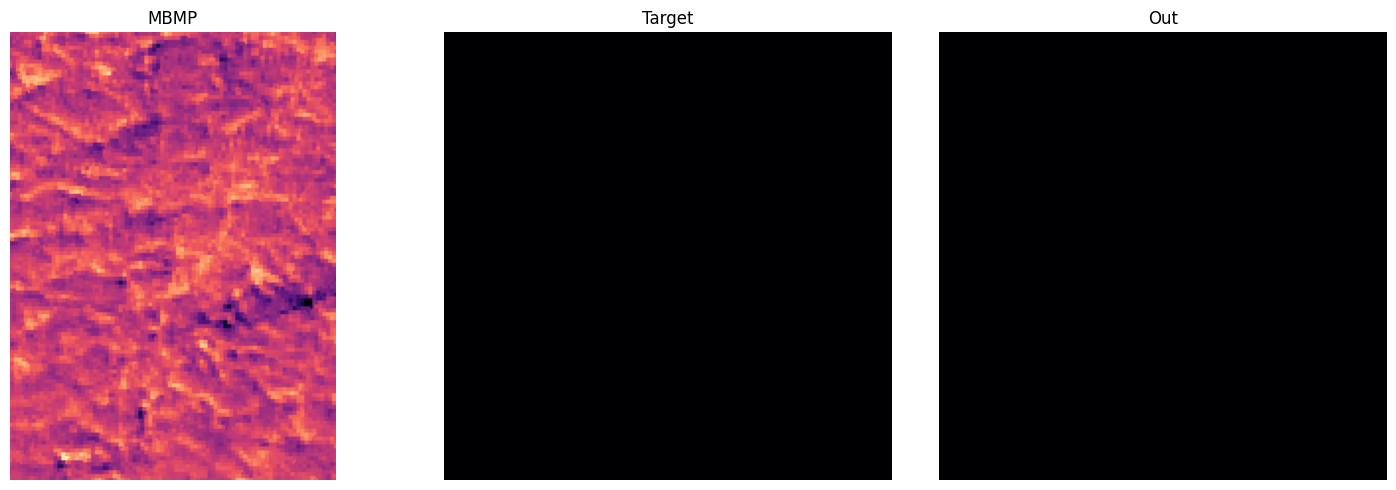

neg
100.0


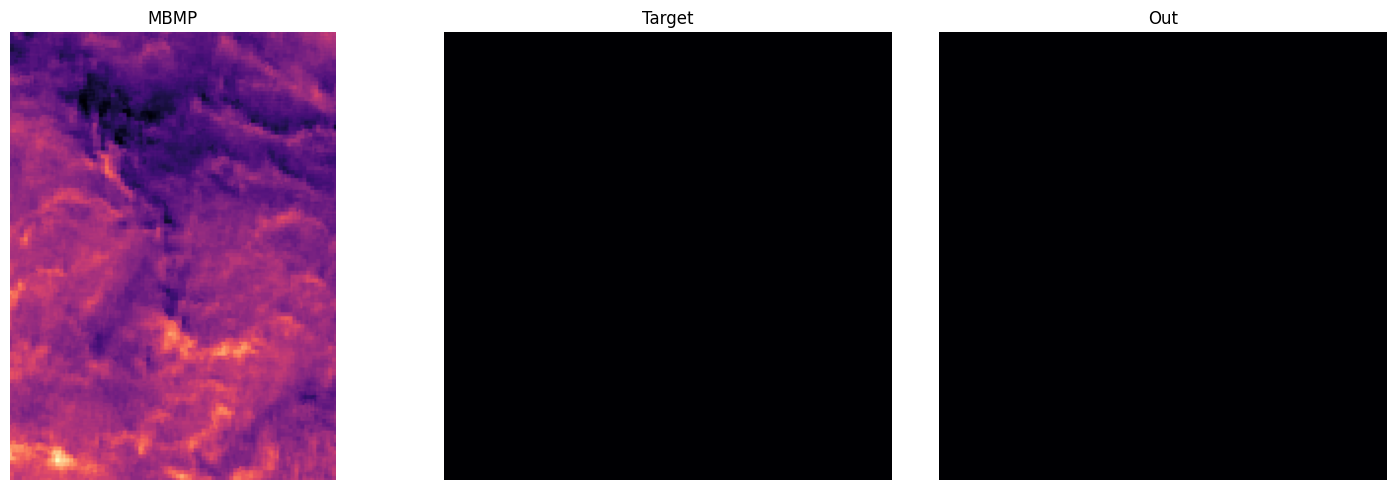

neg
3.8314176098413117e-07


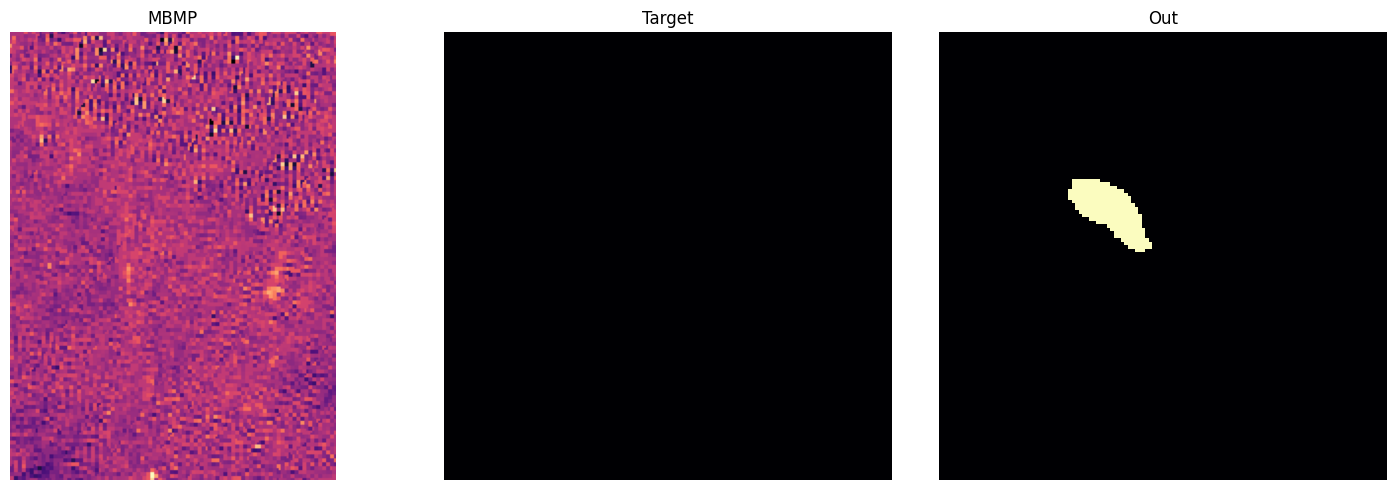

neg
100.0


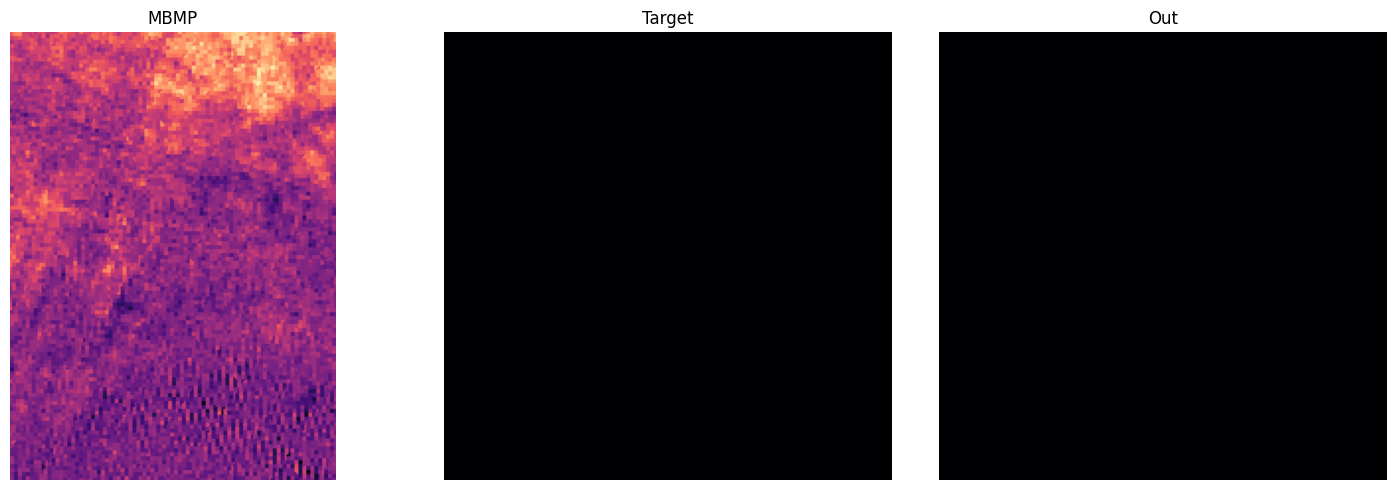

pos
73.10664610029885


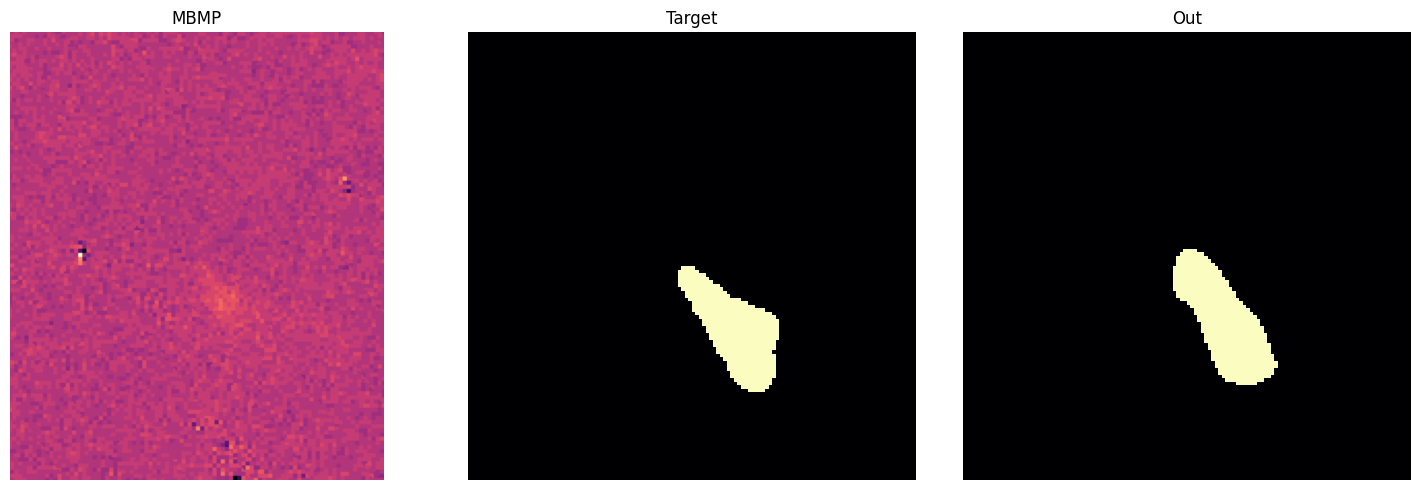

neg
100.0


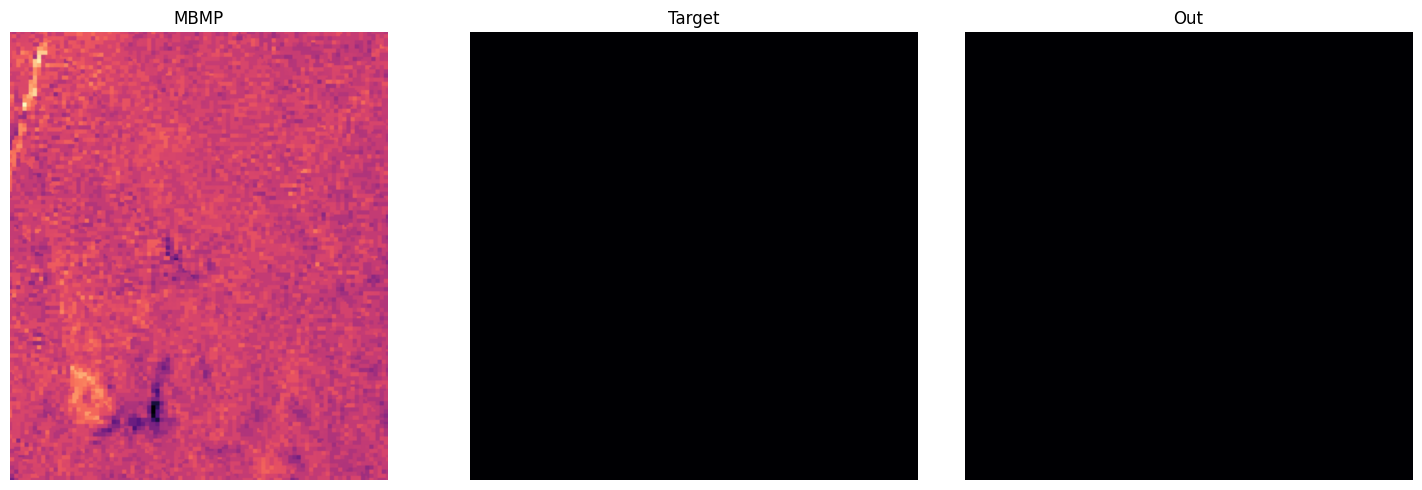

neg
100.0


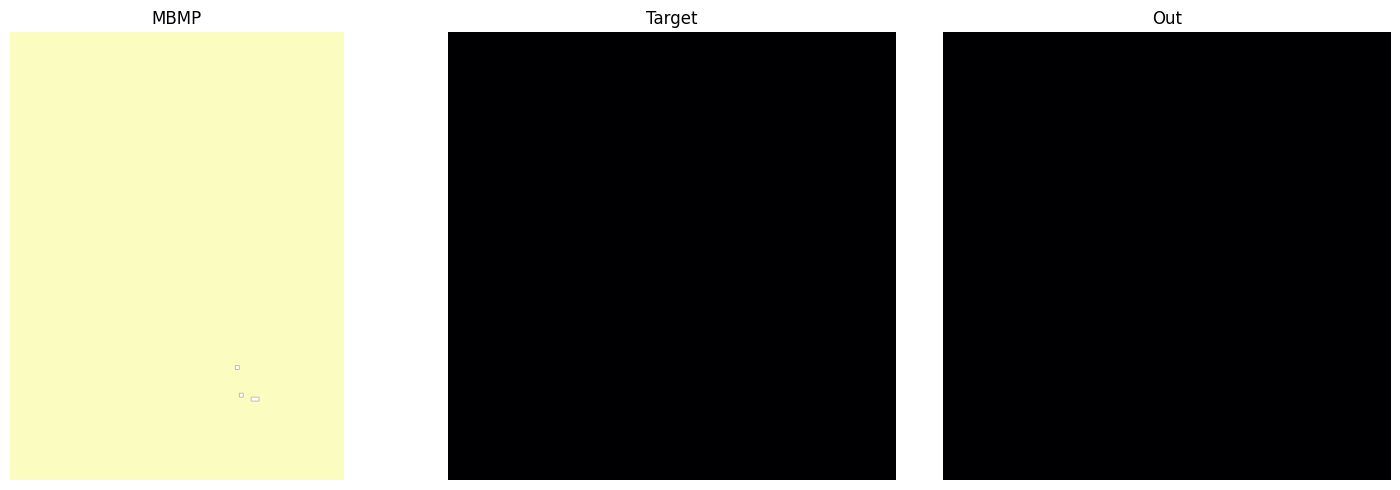

pos
3.0131828568489967


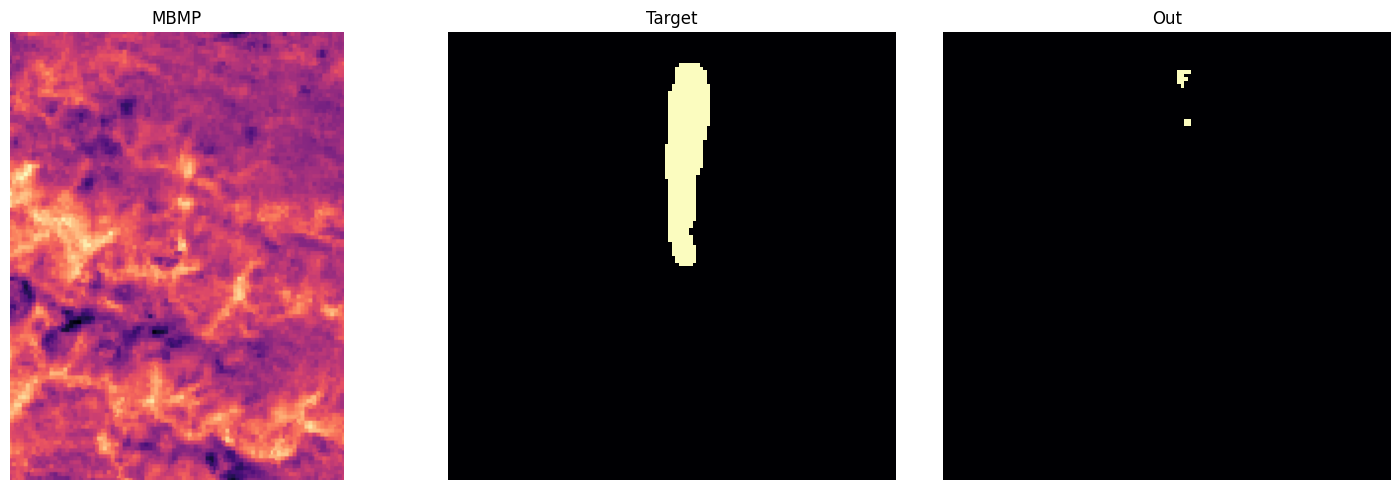

neg
100.0


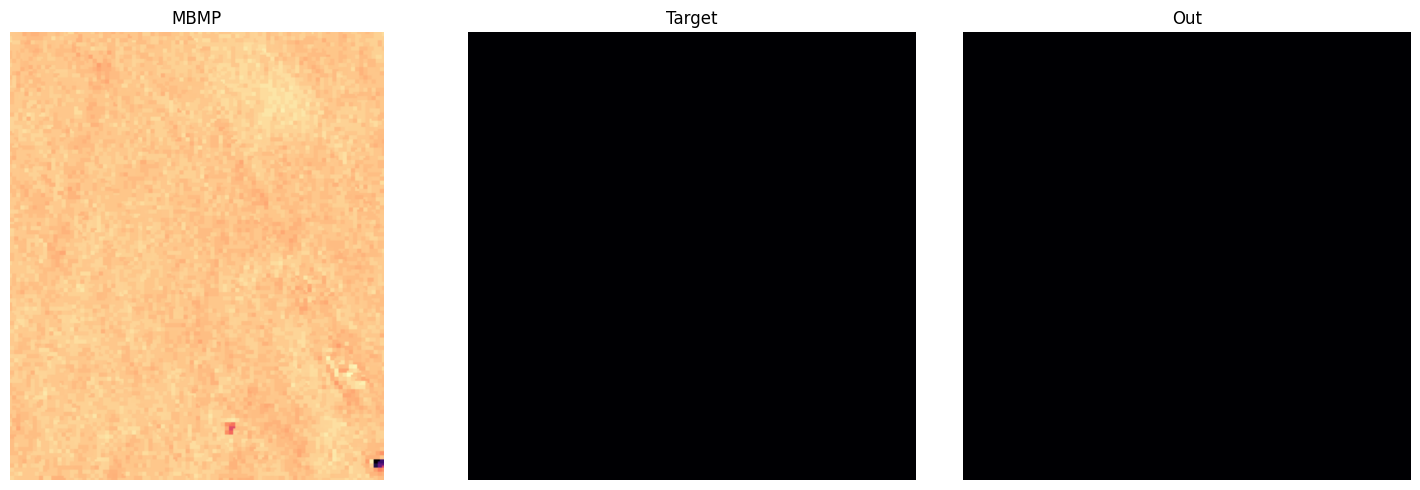

pos
44.99205096185683


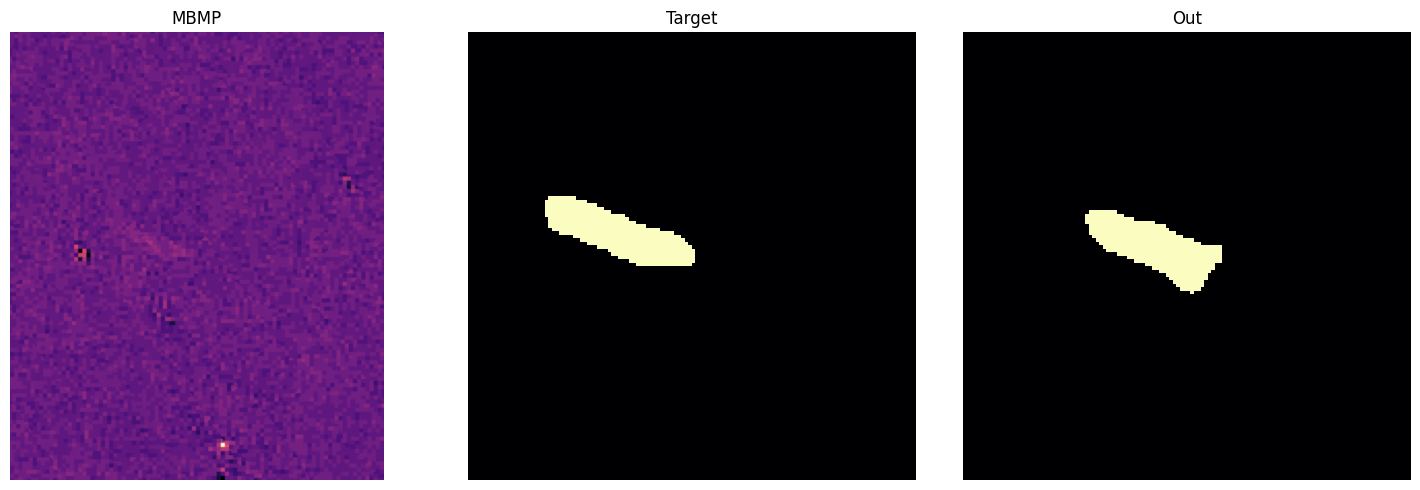

neg
100.0


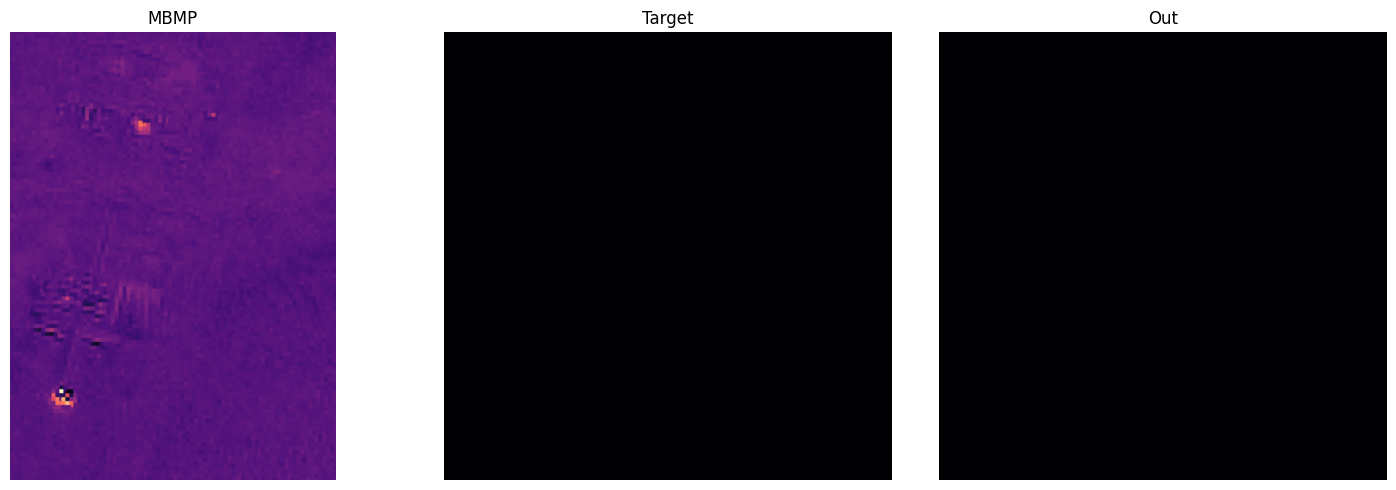

neg
100.0


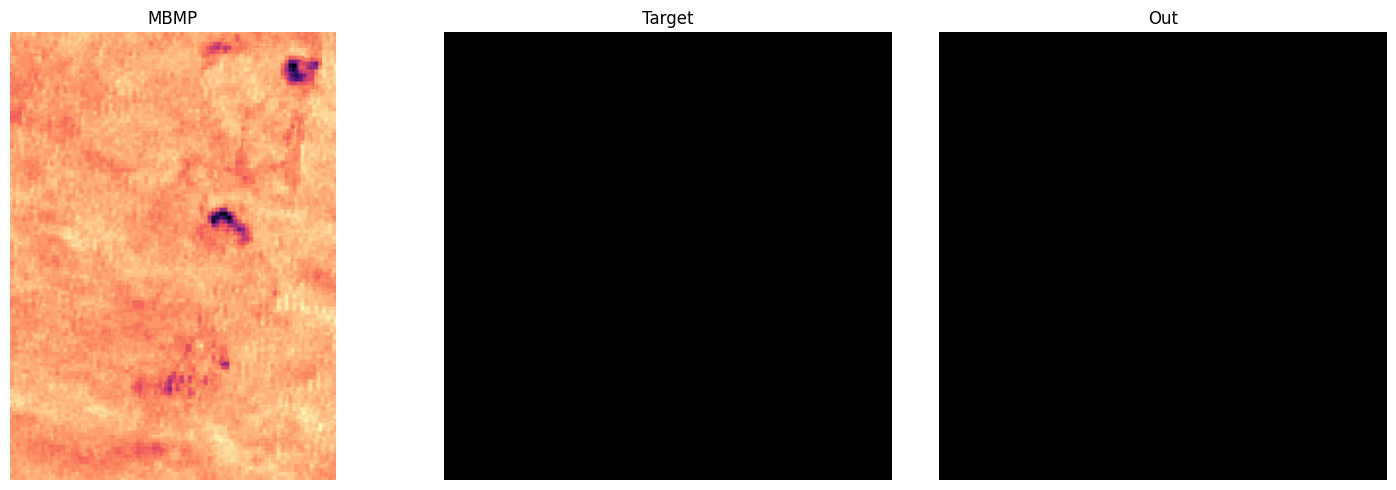

neg
100.0


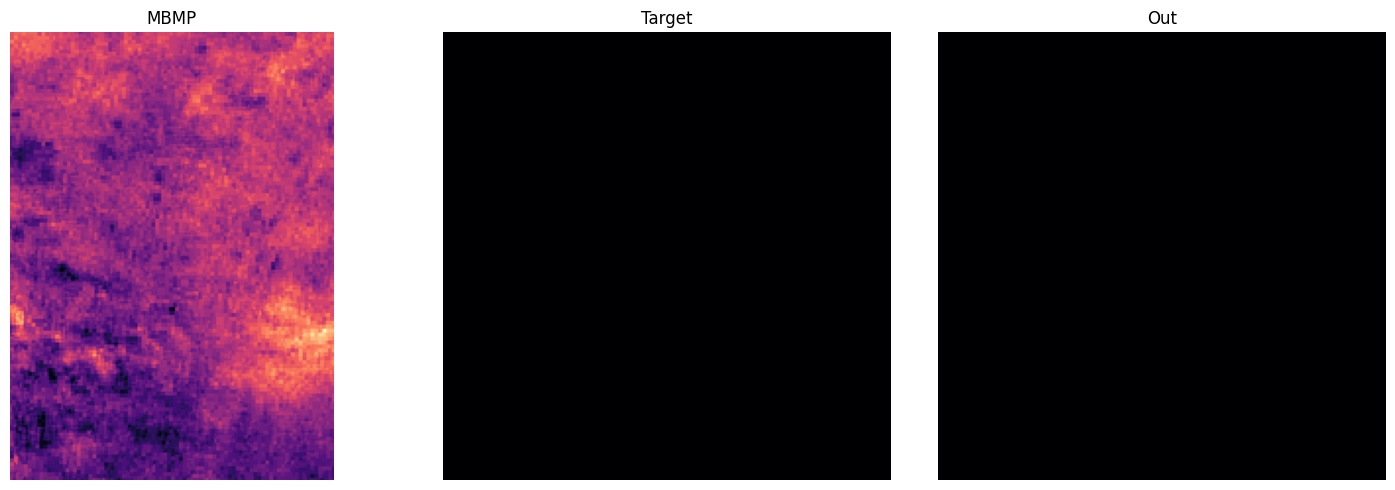

neg
100.0


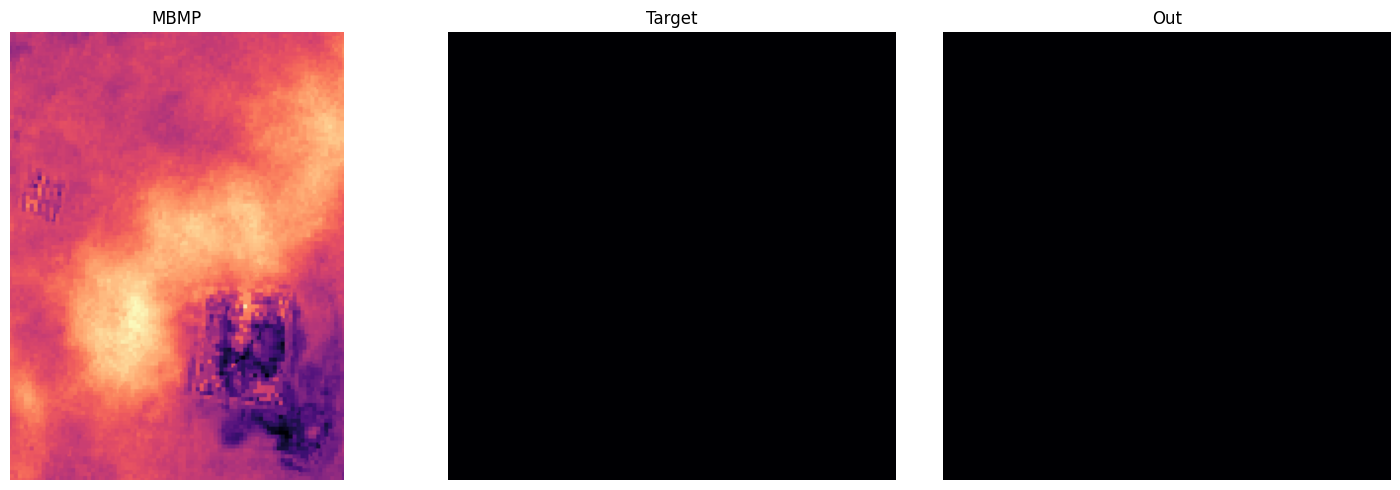

neg
100.0


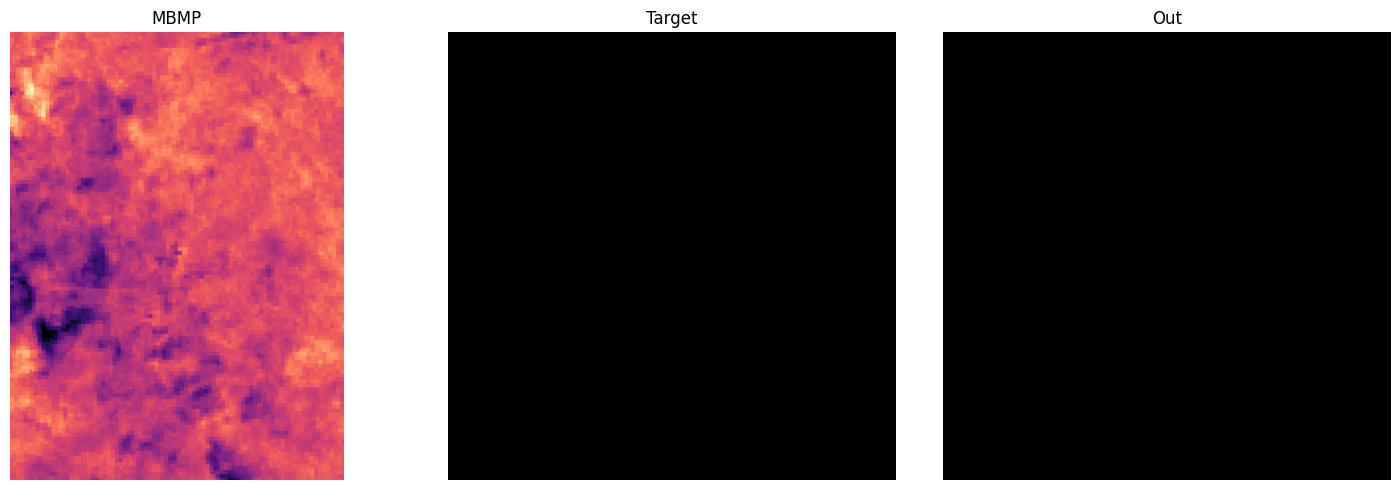

In [16]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
